# Dataset Distillation

Dataset distillation ([Maclaurin et al. 2015](https://arxiv.org/pdf/1502.03492.pdf), [Wang et al. 2020](https://arxiv.org/pdf/1811.10959.pdf) ) aims to learn a small synthetic training dataset such that a model trained
on this learned data set achieves small loss on the original training set.

## Bi-level problem

Dataset distillation can be written formally as a bi-level problem, where in the inner problem we estimate a logistic regression
model $x^\star(\theta) \in \mathbb{R}^{p \times k}$ trained on the distilled images $\theta \in
\mathbb{R}^{k \times p}$, while in the outer problem we want to minimize the loss
achieved by $x^\star(\theta)$ over the training set: 

\begin{equation}
\underbrace{\min_{\theta \in \mathbb{R}^{k \times p}} f(x^\star(\theta), X_{\text{tr}}; y_{\text{tr}})}_{\text{outer problem}} ~\text{ subject to }~ x^\star(\theta) \in \underbrace{\text{argmin}_{x \in \mathbb{R}^{p \times k}} f(x, \theta; [k]) + \varepsilon \|x\|^2\,}_{\text{inner problem}},
\end{equation}

where $f(W, X; y) := \ell(y, XW)$, $\ell$ denotes the
multiclass logistic regression loss, and
$\varepsilon = 10^{-3}$ is a regularization parameter that we found had
a very positive effect on convergence.



In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

import jax
from jax import numpy as jnp

from colabtools import adhoc_import

  from jaxopt import gradient_descent
  from jaxopt import loss


Some examples


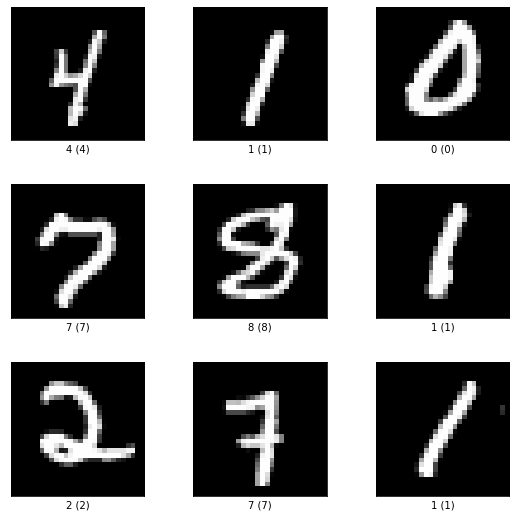

In [ ]:
# load mnist
mnist_train, ds_info = tfds.load(name="mnist", split="train", with_info=True)
images = jnp.array([ex['image'].ravel() for ex in tfds.as_numpy(mnist_train)]) / 255.0
labels = jnp.array([ex['label'] for ex in tfds.as_numpy(mnist_train)])

mnist_test = tfds.load(name="mnist", split="test")
images_test = jnp.array([ex['image'].ravel() for ex in tfds.as_numpy(mnist_test)]) / 255.0
labels_test = jnp.array([ex['label'] for ex in tfds.as_numpy(mnist_test)])

print("Some examples")
fig = tfds.show_examples(mnist_train, ds_info)

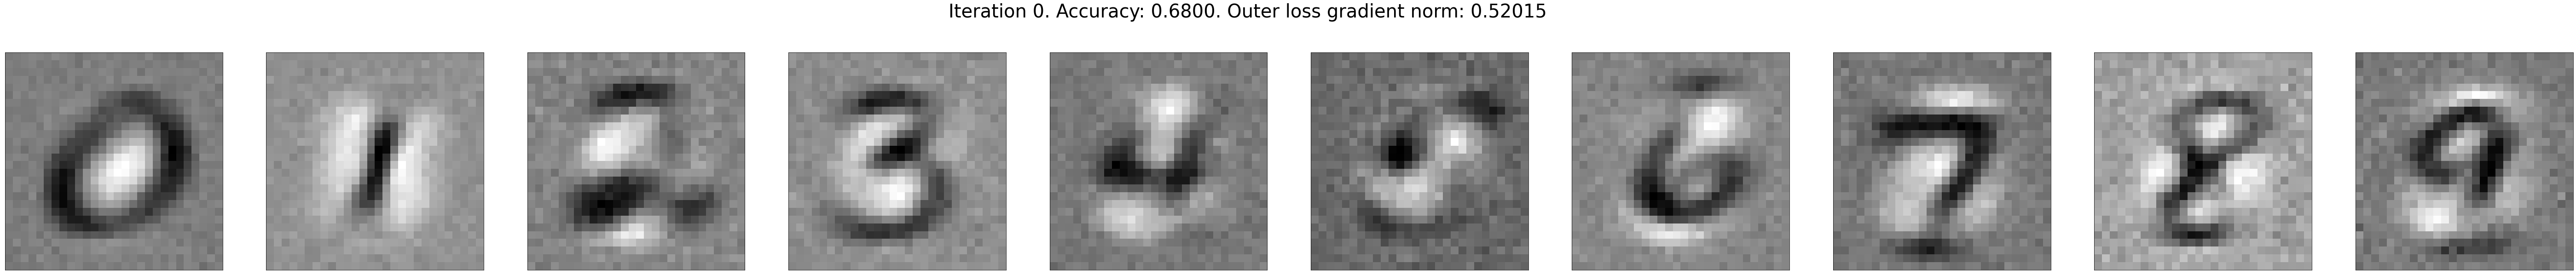

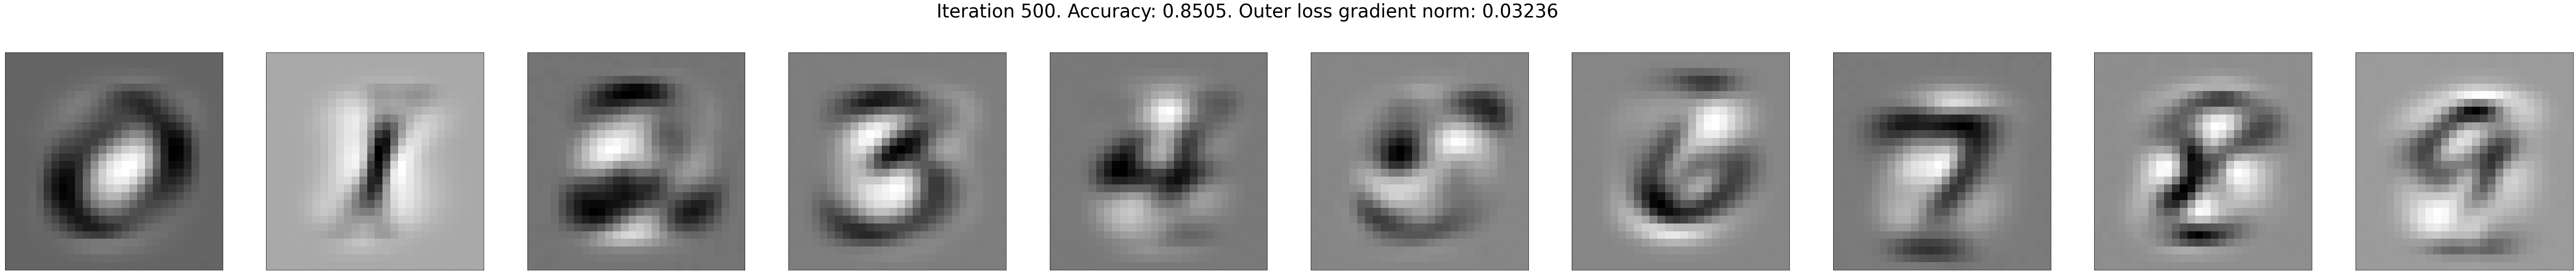

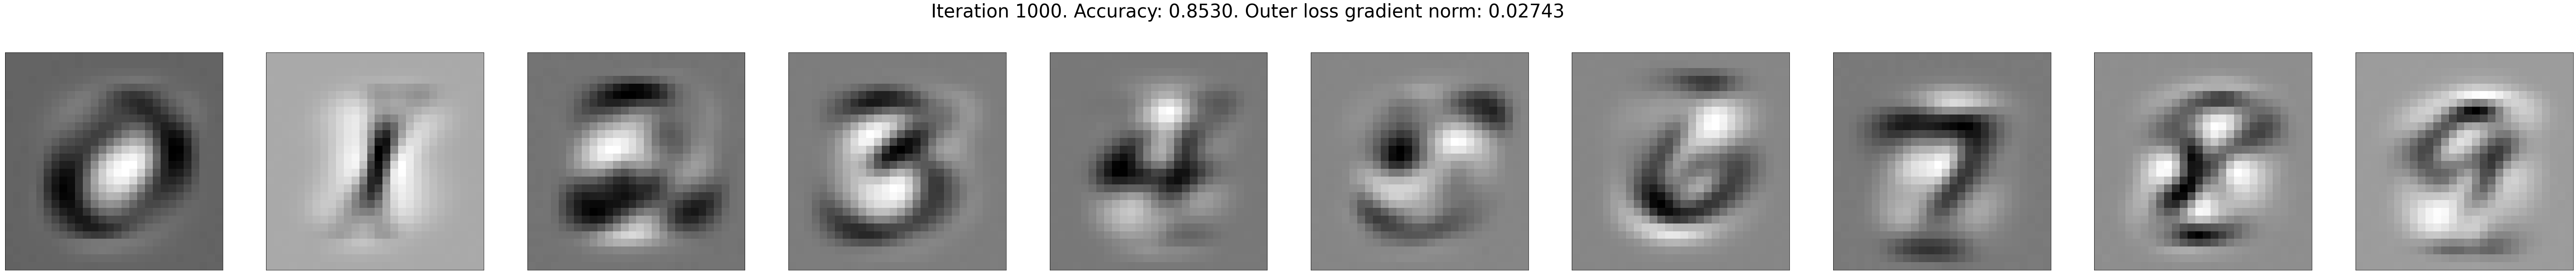

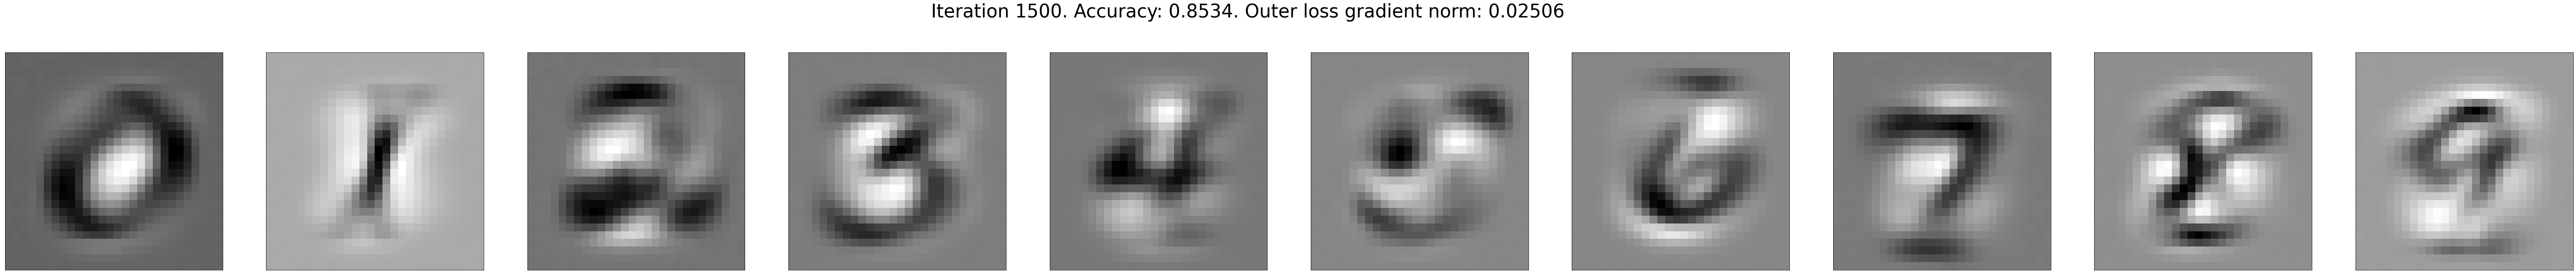

In [ ]:
# do gradient descent on the outer loss. 

# parameters of the logistic regression problem
params = jnp.ones((28 * 28, 10))

rng = jax.random.PRNGKey(0)
estimated_img = jax.random.normal(rng, (10, 28 * 28)) / (28 * 28)

# vt will be the momentum term
vt = jnp.zeros_like(estimated_img)


# optimization parameters for the outer loss
stepsize = 1
momentum = 0.9
maxiter = 2000
logloss = jax.vmap(loss.multiclass_logistic_loss)

# amount of L2 reglarization of the inner problem. This helps both the
# convergence of the inner problem and the computation of the hypergradient
l2reg = 1e-1

# the inner problem computes the model trained on the 10 images from
# estimated_img
def inner_loss(x, params_fun=estimated_img):
  scores = jnp.dot(params_fun, x)
  return jnp.mean(logloss(jnp.arange(10), scores)) + l2reg * jnp.sum(x * x)


all_ft = []
all_ft_unrolled = []
for it in range(maxiter):

  inner_solver = gradient_descent.make_solver_fun(
      inner_loss, params)

  def outer_loss(img):
    inner_sol = inner_solver(img)
    scores = jnp.dot(images, inner_sol)
    return jnp.mean(logloss(labels, scores)), inner_sol

  (ft, params), gt = jax.value_and_grad(outer_loss, has_aux=True)(estimated_img)
  vt = momentum * vt + gt
  estimated_img -= (stepsize  / (it + 1)) * vt

  # print progress and plot current results every 100
  if it % 500 == 0:

    # compute accuracy on test set
    inner_sol = inner_solver(estimated_img)
    scores_test = jnp.dot(images_test, inner_sol)
    accuracy = jnp.mean(jnp.argmax(scores_test, -1) == labels_test)

    fig, axarr = plt.subplots(1, 10, figsize=(10 * 10, 1 * 10))
    plt.suptitle(
        "Iteration %s. Accuracy: %.4f. Outer loss gradient norm: %.5f" % \
        (it, accuracy, jnp.linalg.norm(gt)), fontsize=40)
    for i in range(10):
      img_i = estimated_img[i].reshape((28, 28))
      axarr[i].imshow(img_i / jnp.abs(img_i).max(), cmap=plt.cm.gray_r)
      axarr[i].set_xticks(())
      axarr[i].set_yticks(())
    plt.show()